In [1]:
import torch
import torch.nn as nn
from typing import Optional
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
device = torch.device("cuda")

In [4]:
def plotLoss(loss: list, type: str) -> None:
        
        """
        plotLoss is a function that plots the loss of the model

        Args:
            loss (list): it takes a list of loss
            type (str): it takes a string of the type of loss
        """        
        
        plt.plot(loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{type} Loss')
        plt.show()

In [5]:
class MyPlannerTransformer(nn.Module):
    
    def __init__(self, d_model=16,nhead = 2,num_encoder_layers = 2, num_decoder_layers=2, dropout = 0.1, dim_feedforward = 2048) -> None:
        super().__init__()
        self.transformer = nn.Transformer(
            d_model,
            nhead,
            num_encoder_layers,
            num_decoder_layers,
            dim_feedforward,
            dropout,
            batch_first=True
        )
        # map tgt to have the same number of features as src
        self.input = nn.Linear(5, d_model)
        self.tgt = nn.Linear(2, d_model)
        self.output = nn.Linear(d_model, 2)

    def forward(
        self,
        src: torch.tensor,
        tgt: torch.tensor,
        src_mask: Optional[torch.tensor]=None,
        tgt_mask: Optional[torch.tensor]=None,
        memory_mask: Optional[torch.tensor]=None,
        src_key_padding_mask: Optional[torch.tensor]=None,
        tgt_key_padding_mask: Optional[torch.tensor]=None,
        memory_key_padding_mask: Optional[torch.tensor]=None,
        max_len: Optional[int]=None,
        
    )->torch.tensor:
        src = self.input(src)
        tgt = self.tgt(tgt)
        out = self.transformer(src, tgt)
        out = out[:,:,:2]
        return out
    
    
    def predict(self, src: torch.tensor, tgt: Optional[torch.tensor] = None) -> torch.tensor:
        
        """
        predict v3 is a function that uses the transformer model to predict the next waypoints
        it works by auto-regressive property of the transformer model
        this function is used to predict the entire sequence at once
        
        Args:
            src (torch.tensor):
            
            takes a tensor of shape (sequence, 5)
            in our case sequence is 10 and 5 is the number of features
            
        Returns:
            torch.tensor:
            
            tgt tensor of shape (outputSequence, 2)
            outputSequence is the number of waypoints to predict
            2 is the number of features
        """
        
        self.eval()
        src = src.reshape(-1, 10, 5)
        if tgt is None:
            tgt = torch.zeros((1, 1, 2)).cuda()
        with torch.no_grad():
                for _ in range(4):
                    prediction = self.forward(src, tgt)
                    tgt = torch.cat((tgt, prediction[:,-1:]), dim=1)

        return tgt.reshape(-1,2)
    
        
    
    def trainModel(self,model, trainLoader, validLoader,epochs = 10):
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        VAL_LOSS = []
        TRAIN_LOSS = []

        for epoch in range(epochs):
            model.train()
            total_loss = 0.0

            for batch_idx, (src, tgt) in enumerate(trainLoader):
               

                optimizer.zero_grad()
                output = model(src, tgt[:, :-1, :])  # Use teacher forcing for training

                # Flatten the output and target for computing the loss
                loss = criterion(output.view(-1, 2), tgt[:, 1:, :].contiguous().view(-1, 2))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / len(trainLoader)
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}")
            TRAIN_LOSS.append(average_loss)

            #Validation Remember to uncomment 
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for val_src, val_tgt in validLoader:
                    
                    val_output = model(val_src, val_tgt[:, :-1, :])  # No teacher forcing for validation
                    val_loss += criterion(val_output.view(-1, 2), val_tgt[:, 1:, :].contiguous().view(-1, 2)).item()

            average_val_loss = val_loss / len(validLoader)
            print(f"Validation Loss: {average_val_loss:.4f}")
            VAL_LOSS.append(average_val_loss)
            

        return TRAIN_LOSS, VAL_LOSS
    

        
    

In [6]:
def createModel(path: str) -> MyPlannerTransformer:
    """
    Create a planning model from a saved state dict

    Parameters
    ----------
    path : str
        Path to the saved state dict

    Returns
    -------
    MyPlannerTransformer
        Planning model with the saved state dict loaded
    """
    model = MyPlannerTransformer()
    model.load_state_dict(torch.load(path))
    model.cuda()
    return model

In [7]:
class DataSet1():
    
    def __init__(self,) -> None:
        pass

    
    def __loadData(self,dir: str) -> torch.tensor: 
        data = torch.load(dir).cuda()
        return data
    
    def prepareData(self,trainDir: str, validDir) -> torch.tensor:
        srcTrain = self.__loadData(f'{trainDir}/src_train.pt')
        tgtTrain = self.__loadData(f'{trainDir}/tgt_train.pt')
        srcValid = self.__loadData(f'{validDir}/src_valid.pt')
        tgtValid = self.__loadData(f'{validDir}/tgt_valid.pt')
        
        srcSeqLength = 10
        srcNumOfSequencesTrain = srcTrain.size(0) // srcSeqLength
        tgtSeqLength = 4
        tgtNumOfSequencesTrain = tgtTrain.size(0) // tgtSeqLength
        srcNumOfSequencesValid = srcValid.size(0) // srcSeqLength
        tgtNumOfSequencesValid = tgtValid.size(0) // tgtSeqLength
        # reshape the tensors
        srcTrain = srcTrain[:srcNumOfSequencesTrain * srcSeqLength, :].view(srcNumOfSequencesTrain, srcSeqLength, -1).cuda()
        tgtTrain = tgtTrain[:tgtNumOfSequencesTrain * tgtSeqLength, :].view(tgtNumOfSequencesTrain, tgtSeqLength, -1).cuda()
        srcValid = srcValid[:srcNumOfSequencesValid * srcSeqLength, :].view(srcNumOfSequencesValid, srcSeqLength, -1).cuda()
        tgtValid = tgtValid[:tgtNumOfSequencesValid * tgtSeqLength, :].view(tgtNumOfSequencesValid, tgtSeqLength, -1).cuda()
        
        return srcTrain, tgtTrain, srcValid, tgtValid

In [8]:
class DataSet2():
    
    def __init__(self) -> None:
        pass
    
    def prepareData(self, srcPath, tgtPath):
        srcTrain = torch.empty(0, 5).cuda()
        tgtTrain = torch.empty(0, 2).cuda()
        srcValid = torch.empty(0, 5).cuda()
        tgtValid = torch.empty(0, 2).cuda()
        for files in os.listdir(srcPath+"train"):
            srcTrain = torch.cat((srcTrain, torch.load(f'{srcPath+"train"}/{files}').cuda())).cuda()

        for files in os.listdir(tgtPath+"train"):
            tgtTrain = torch.cat((tgtTrain, torch.load(f'{tgtPath+"train"}/{files}').cuda())).cuda()
        
        for files in os.listdir(srcPath+"valid"):
            srcValid = torch.cat((srcValid, torch.load(f'{srcPath+"valid"}/{files}').cuda())).cuda()
        
        for files in os.listdir(tgtPath+"valid"):
            tgtValid = torch.cat((tgtValid, torch.load(f'{tgtPath+"valid"}/{files}').cuda())).cuda()
                  
        srcSeqLength = 10
        srcNumOfSequencesTrain = srcTrain.size(0) // srcSeqLength
        tgtSeqLength = 4
        tgtNumOfSequencesTrain = tgtTrain.size(0) // tgtSeqLength
        srcNumOfSequencesValid = srcValid.size(0) // srcSeqLength
        tgtNumOfSequencesValid = tgtValid.size(0) // tgtSeqLength
        # reshape the tensors
        srcTrain = srcTrain[:srcNumOfSequencesTrain * srcSeqLength, :].view(srcNumOfSequencesTrain, srcSeqLength, -1).cuda()
        tgtTrain = tgtTrain[:tgtNumOfSequencesTrain * tgtSeqLength, :].view(tgtNumOfSequencesTrain, tgtSeqLength, -1).cuda()
        srcValid = srcValid[:srcNumOfSequencesValid * srcSeqLength, :].view(srcNumOfSequencesValid, srcSeqLength, -1).cuda()
        tgtValid = tgtValid[:tgtNumOfSequencesValid * tgtSeqLength, :].view(tgtNumOfSequencesValid, tgtSeqLength, -1).cuda()
    
        return srcTrain, tgtTrain, srcValid, tgtValid

In [9]:
data1 = DataSet1()

In [10]:
data2 = DataSet2()

In [11]:
src_path = "../inputs/tensorsV2/inputs/"  # Replace with the path to your directory
tgt_path = "../inputs/tensorsV2/outputs/"

In [12]:
# srcTrain, tgtTrain, srcValid, tgtValid = data1.prepareData('../inputs/tensors/train', '../inputs/tensors/valid')

In [13]:
srcTrain, tgtTrain, srcValid, tgtValid = data2.prepareData(src_path, tgt_path)

In [14]:
trainData = list(zip(srcTrain, tgtTrain))
validData = list(zip(srcValid, tgtValid))

trainLoader = DataLoader(trainData, batch_size=100, shuffle=True)
validLoader = DataLoader(validData, batch_size=100, shuffle=True)

In [15]:
len(trainLoader.dataset)

51112

In [16]:
model = MyPlannerTransformer()

In [17]:
model.to(device)

MyPlannerTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention

In [18]:
train_loss, val_loss =  model.trainModel(model, trainLoader,validLoader, epochs=3)

Epoch [1/3], Loss: 920.5709
Validation Loss: 849.4373
Epoch [2/3], Loss: 842.4127
Validation Loss: 777.4479
Epoch [3/3], Loss: 773.2464
Validation Loss: 710.2129


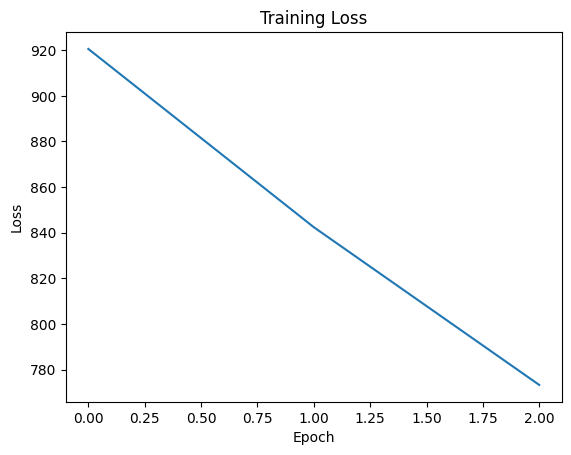

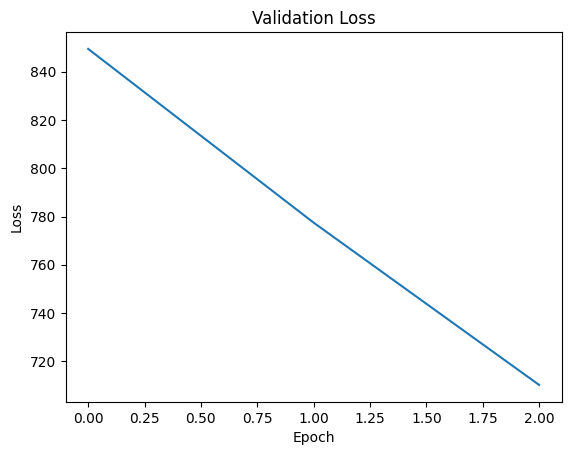

In [25]:
plotLoss(train_loss, 'Training')
plotLoss(val_loss, 'Validation')

In [20]:
torch.save(model.state_dict(), '../notebooks/myPlannerTransformer.pt')

model.load_state_dict(torch.load('../notebooks/myPlannerTransformer.pt'))


def pathPredict(model, src: torch.tensor,tgt: Optional[torch.tensor] = None):
        
    try:
        last_prediction = torch.load('../notebooks/lastPredicitons.pt')
        output = model.predict(src, last_prediction)
        torch.save(output[-1].reshape(1,-1,2), '../notebooks/lastPredicitons.pt')
        return output
    except:
        output = model.predict(src)
        torch.save(output[-1].reshape(1,-1,2), '../notebooks/lastPredicitons.pt')
        return output


In [21]:
pathPredict(model, srcTrain[4])

tensor([[0.0000, 0.0000],
        [0.2794, 0.2133],
        [0.5125, 0.3810],
        [0.7137, 0.5169],
        [0.8898, 0.6278]], device='cuda:0')